## **Chargement des bibliothéques :**

In [1]:
# Importer les bibliothèques nécessaires
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt




## **Chargement des données :**

In [6]:
!curl -L -o sentiment140.zip https://www.kaggle.com/api/v1/datasets/download/kazanova/sentiment140
!unzip sentiment140.zip -d ./sentiment140_data
columns = ['target', 'ids', 'date', 'flag', 'user', 'text']
path = './sentiment140_data/training.1600000.processed.noemoticon.csv'
data = pd.read_csv(path, sep=',', encoding='latin1', names=columns)

# Balance the dataset
positive_tweets = data[data['target'] == 4]
negative_tweets = data[data['target'] == 0]

# Sample 40,000 of each
positive_sample = positive_tweets.sample(n=40000, random_state=42)
negative_sample = negative_tweets.sample(n=40000, random_state=42)

# Combine the samples
data = pd.concat([positive_sample, negative_sample])

# Reset the index
data.reset_index(drop=True, inplace=True)

# Aperçu des premières lignes
print(data.head())


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 80.9M  100 80.9M    0     0  45.9M      0  0:00:01  0:00:01 --:--:-- 95.3M
Archive:  sentiment140.zip
  inflating: ./sentiment140_data/training.1600000.processed.noemoticon.csv  
   target         ids                          date      flag            user  \
0       4  1881179620  Fri May 22 03:51:54 PDT 2009  NO_QUERY        tarawade   
1       4  1970537555  Sat May 30 04:15:49 PDT 2009  NO_QUERY  Millie_stillie   
2       4  2001154935  Tue Jun 02 00:00:21 PDT 2009  NO_QUERY         zsangel   
3       4  2053074174  Sat Jun 06 03:10:08 PDT 2009  NO_QUERY     krisignacio   
4       4  1793548492  Thu May 14 03:06:55 PDT 2009  NO_QUERY         _DrInE_   

                                                text  
0  Is lookin 4ward to a long weekend  

## **Exploration des données :**

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   target  80000 non-null  int64 
 1   ids     80000 non-null  int64 
 2   date    80000 non-null  object
 3   flag    80000 non-null  object
 4   user    80000 non-null  object
 5   text    80000 non-null  object
dtypes: int64(2), object(4)
memory usage: 3.7+ MB


# **EDA :**

In [8]:
# Afficher les valeurs uniques de la colonne target
print("Valeurs uniques dans target :", data['target'].unique())


Valeurs uniques dans target : [4 0]


In [9]:
# Informations sur le DataFrame
print("Informations sur les données :")
print(data.info())

# Aperçu des valeurs manquantes
print("\nValeurs manquantes par colonne :")
print(data.isnull().sum())

# Distribution des sentiments (0 = Négatif, 1 = Positif)
print("\nDistribution des sentiments :")
print(data['target'].value_counts())



Informations sur les données :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   target  80000 non-null  int64 
 1   ids     80000 non-null  int64 
 2   date    80000 non-null  object
 3   flag    80000 non-null  object
 4   user    80000 non-null  object
 5   text    80000 non-null  object
dtypes: int64(2), object(4)
memory usage: 3.7+ MB
None

Valeurs manquantes par colonne :
target    0
ids       0
date      0
flag      0
user      0
text      0
dtype: int64

Distribution des sentiments :
target
4    40000
0    40000
Name: count, dtype: int64


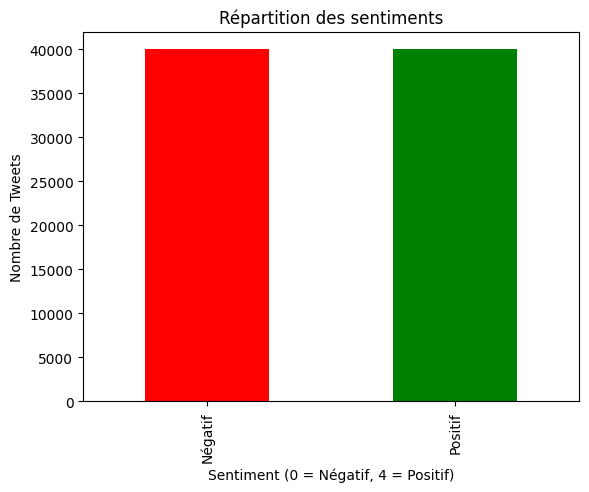

In [10]:
import matplotlib.pyplot as plt

# Distribution des sentiments
sentiment_counts = data['target'].value_counts()
sentiment_counts.plot(kind='bar', color=['red', 'green'])
plt.title('Répartition des sentiments')
plt.xlabel('Sentiment (0 = Négatif, 4 = Positif)')
plt.ylabel('Nombre de Tweets')
plt.xticks(ticks=[0, 1], labels=['Négatif', 'Positif'])
plt.show()


In [11]:
print("Exemples de tweets avant nettoyage :")
print(data[['text']].head())


Exemples de tweets avant nettoyage :
                                                text
0  Is lookin 4ward to a long weekend  really dont...
1  #myweakness  Is music and i live to meet the p...
2           figured out the Internet on my new iPod 
3  @hillsongunited can't wait to worship with you...
4  @sillybeggar Congrats James !! I'm sure the bo...


## **Le nettoyage des textes :**

In [12]:
import re

# Fonction pour nettoyer les tweets
def clean_text(text):
    if not isinstance(text, str):  # Gérer les cas où le texte est None
        return ""
    text = re.sub(r'http[s]?://\S+', '', text)  # Retirer les URLs
    text = re.sub(r'www\.\S+', '', text)        # Retirer les URLs avec www
    text = re.sub(r'@\w+', '', text)           # Retirer les mentions
    text = re.sub(r'#[A-Za-z0-9_]+', '', text) # Retirer les hashtags
    text = re.sub(r'[^a-zA-Z\s]', '', text)    # Garder uniquement les lettres
    text = text.lower()                        # Convertir en minuscules
    text = re.sub(r'\s+', ' ', text).strip()   # Supprimer les espaces multiples
    return text

# Appliquer le nettoyage sur la colonne 'text'
data['clean_text'] = data['text'].apply(clean_text)

# Aperçu des tweets nettoyés
print("Exemple de tweets nettoyés :")
print(data[['text', 'clean_text']].head())


Exemple de tweets nettoyés :
                                                text  \
0  Is lookin 4ward to a long weekend  really dont...   
1  #myweakness  Is music and i live to meet the p...   
2           figured out the Internet on my new iPod    
3  @hillsongunited can't wait to worship with you...   
4  @sillybeggar Congrats James !! I'm sure the bo...   

                                          clean_text  
0  is lookin ward to a long weekend really dont w...  
1  is music and i live to meet the people who mak...  
2            figured out the internet on my new ipod  
3  cant wait to worship with you guys tonight itl...  
4  congrats james im sure the book is going to be...  


## **Suppression des doublons :**

In [13]:
# Supprimer les doublons basés sur la colonne 'clean_text'
avant_suppression = data.shape[0]
data.drop_duplicates(subset='clean_text', inplace=True)
apres_suppression = data.shape[0]

# Afficher le nombre de tweets avant et après suppression
print(f"Nombre de tweets avant suppression des doublons : {avant_suppression}")
print(f"Nombre de tweets après suppression des doublons : {apres_suppression}")


Nombre de tweets avant suppression des doublons : 80000
Nombre de tweets après suppression des doublons : 78200


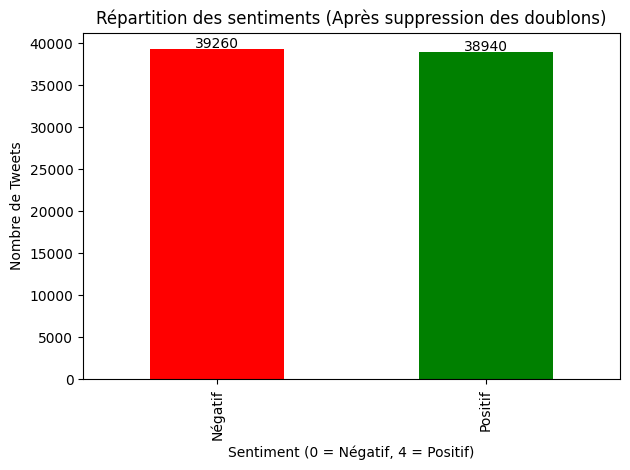

In [14]:
import matplotlib.pyplot as plt

# Distribution des sentiments après suppression des doublons
data.drop_duplicates(subset='clean_text', inplace=True)
sentiment_counts = data['target'].value_counts()

# Création du graphique
sentiment_counts.plot(kind='bar', color=['red', 'green'])
plt.title('Répartition des sentiments (Après suppression des doublons)')
plt.xlabel('Sentiment (0 = Négatif, 4 = Positif)')
plt.ylabel('Nombre de Tweets')
plt.xticks(ticks=[0, 1], labels=['Négatif', 'Positif'])

# Ajouter les valeurs au-dessus des barres
for i, value in enumerate(sentiment_counts):
    plt.text(i, value + 100, str(value), ha='center', fontsize=10)

plt.tight_layout()
plt.show()


# **Prétraitement avancé :**

Nous allons :

Tokeniser : Découper les tweets en mots.
Supprimer les mots vides (stopwords) : Exclure les mots sans valeur significative comme "the", "and".
Lemmatization : Réduire les mots à leur forme racine (ex. : "running" → "run").

In [15]:
import nltk
nltk.download('punkt')  # Redémarre le téléchargement de 'punkt'
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [16]:

import nltk
nltk.data.path.append('/root/nltk_data')


In [17]:
import nltk

# Download 'punkt_tab'
nltk.download('punkt_tab')

# Verify the download and data path
print(nltk.data.path)

# Now try tokenization again
from nltk.tokenize import word_tokenize

text = "Hello, this is a test sentence."
print(word_tokenize(text))

['/root/nltk_data', '/usr/nltk_data', '/usr/share/nltk_data', '/usr/lib/nltk_data', '/usr/share/nltk_data', '/usr/local/share/nltk_data', '/usr/lib/nltk_data', '/usr/local/lib/nltk_data', '/root/nltk_data']
['Hello', ',', 'this', 'is', 'a', 'test', 'sentence', '.']


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [18]:
import nltk
nltk.download('punkt', download_dir='/usr/local/share/nltk_data')


[nltk_data] Downloading package punkt to /usr/local/share/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [19]:
nltk.download('punkt', download_dir='/root/nltk_data')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [20]:
import nltk
nltk.data.path.append('/root/nltk_data')


In [21]:
import nltk
print(nltk.data.path)


['/root/nltk_data', '/usr/nltk_data', '/usr/share/nltk_data', '/usr/lib/nltk_data', '/usr/share/nltk_data', '/usr/local/share/nltk_data', '/usr/lib/nltk_data', '/usr/local/lib/nltk_data', '/root/nltk_data', '/root/nltk_data']


In [22]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Télécharger les ressources nécessaires pour nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Initialiser les outils de traitement
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Fonction pour le prétraitement avancé
def preprocess_text(text):
    tokens = word_tokenize(text)  # Tokenisation
    tokens = [word for word in tokens if word not in stop_words]  # Suppression des mots vides
    tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Lemmatization
    return ' '.join(tokens)

# Appliquer le prétraitement avancé sur la colonne 'clean_text'
data['processed_text'] = data['clean_text'].apply(preprocess_text)

# Aperçu des tweets après prétraitement
print("Exemples de tweets après prétraitement :")
print(data[['clean_text', 'processed_text']].head())


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Exemples de tweets après prétraitement :
                                          clean_text  \
0  is lookin ward to a long weekend really dont w...   
1  is music and i live to meet the people who mak...   
2            figured out the internet on my new ipod   
3  cant wait to worship with you guys tonight itl...   
4  congrats james im sure the book is going to be...   

                                      processed_text  
0  lookin ward long weekend really dont want go w...  
1                        music live meet people make  
2                          figured internet new ipod  
3        cant wait worship guy tonight itll much fun  
4     congrats james im sure book going huge success  


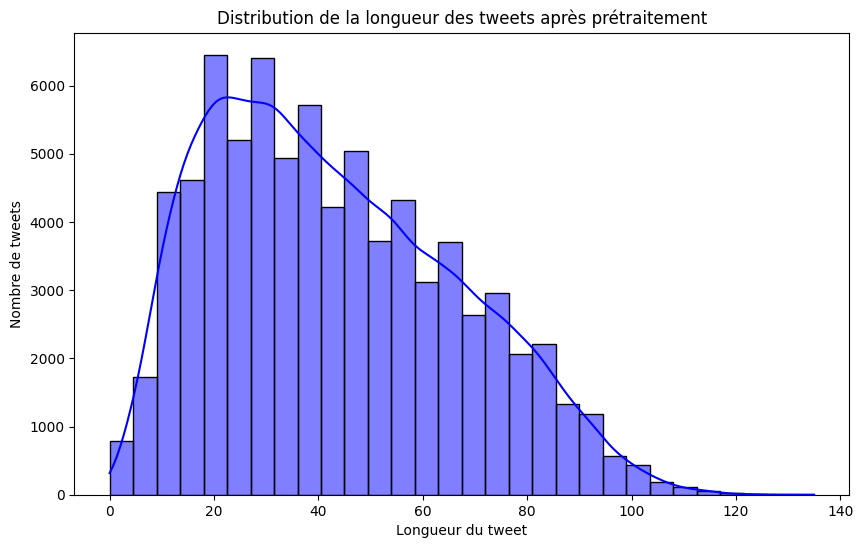

In [23]:
# Calculer la longueur des tweets
data['tweet_length'] = data['processed_text'].apply(len)

# Visualiser la distribution des longueurs des tweets
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(data['tweet_length'], bins=30, kde=True, color='blue')
plt.title('Distribution de la longueur des tweets après prétraitement')
plt.xlabel('Longueur du tweet')
plt.ylabel('Nombre de tweets')
plt.show()


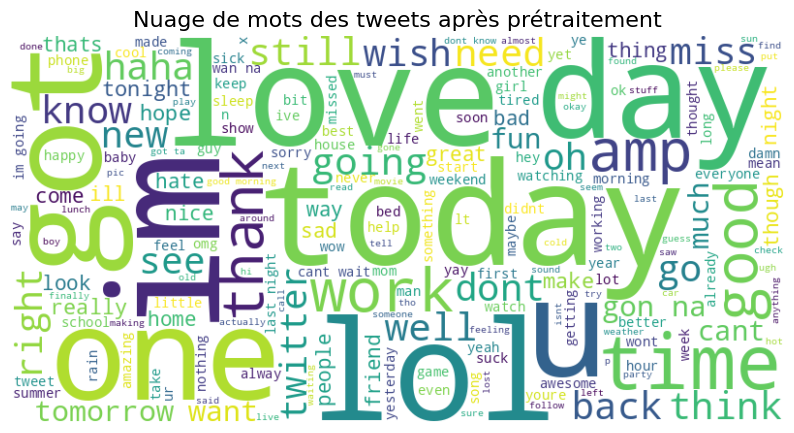

In [24]:
from wordcloud import WordCloud

# Créer une chaîne de texte contenant tous les tweets
all_words = ' '.join(data['processed_text'])

# Générer un nuage de mots
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)

# Afficher le nuage de mots
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Masquer les axes
plt.title('Nuage de mots des tweets après prétraitement', fontsize=16)
plt.show()


<ipython-input-25-2c51091d38f0>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts, y=words, palette='viridis')


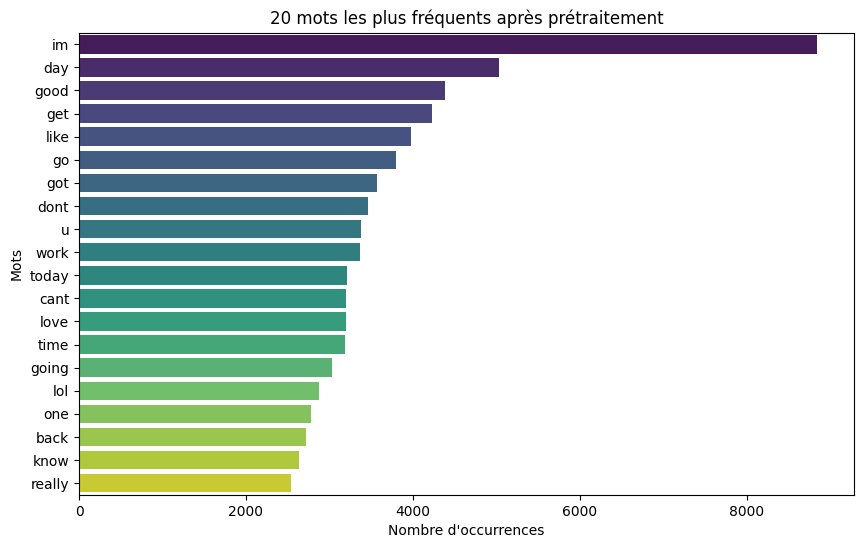

In [25]:
from collections import Counter

# Compter les mots les plus fréquents
word_counts = Counter(' '.join(data['processed_text']).split())

# Afficher les 20 mots les plus fréquents
most_common_words = word_counts.most_common(20)
words, counts = zip(*most_common_words)

plt.figure(figsize=(10, 6))
sns.barplot(x=counts, y=words, palette='viridis')
plt.title('20 mots les plus fréquents après prétraitement')
plt.xlabel('Nombre d\'occurrences')
plt.ylabel('Mots')
plt.show()


# **Représentation vectorielle avec TF-IDF**

Nous allons transformer les tweets en une forme que le modèle peut comprendre, en utilisant TF-IDF (Term Frequency-Inverse Document Frequency), une méthode qui évalue l'importance de chaque mot dans le corpus.

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialiser le vecteur TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)  # Limiter à 5000 mots les plus fréquents
X = vectorizer.fit_transform(data['processed_text'])  # Convertir les tweets en vecteurs TF-IDF

# Afficher la forme de la matrice
print("Représentation TF-IDF terminée. Dimensions :", X.shape)

# Les labels des tweets (positif ou négatif)
y = data['target']


Représentation TF-IDF terminée. Dimensions : (78200, 5000)


#**La division des données :**

In [27]:
from sklearn.model_selection import train_test_split

# Diviser les données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Afficher les dimensions des jeux de données
print("Dimensions du jeu d'entraînement :", X_train.shape)
print("Dimensions du jeu de test :", X_test.shape)


Dimensions du jeu d'entraînement : (62560, 5000)
Dimensions du jeu de test : (15640, 5000)


In [28]:
# Vérifier la répartition des classes dans les données d'entraînement
print("Répartition des classes dans les données d'entraînement :")
print(y_train.value_counts())


Répartition des classes dans les données d'entraînement :
target
0    31408
4    31152
Name: count, dtype: int64


# **Implémentation des modéles :**

### **LogisticRegression**

Rapport de classification pour la Régression Logistique :
              precision    recall  f1-score   support

           0       0.77      0.75      0.76      7852
           4       0.75      0.78      0.76      7788

    accuracy                           0.76     15640
   macro avg       0.76      0.76      0.76     15640
weighted avg       0.76      0.76      0.76     15640



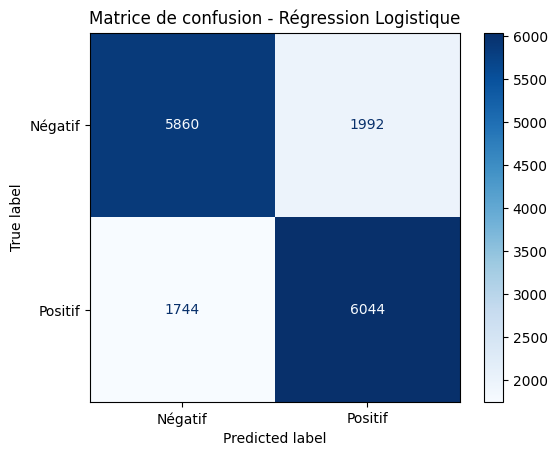

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Entraîner le modèle
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train, y_train)

# Faire des prédictions
y_pred_logistic = logistic_model.predict(X_test)

# Évaluer les performances
print("Rapport de classification pour la Régression Logistique :")
print(classification_report(y_test, y_pred_logistic))

# Matrice de confusion
conf_matrix_logistic = confusion_matrix(y_test, y_pred_logistic)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_logistic, display_labels=['Négatif', 'Positif'])
disp.plot(cmap="Blues")
plt.title("Matrice de confusion - Régression Logistique")
plt.show()


### **SVC :**

Rapport de classification pour le SVM :
              precision    recall  f1-score   support

           0       0.78      0.75      0.76      7852
           4       0.76      0.79      0.77      7788

    accuracy                           0.77     15640
   macro avg       0.77      0.77      0.77     15640
weighted avg       0.77      0.77      0.77     15640



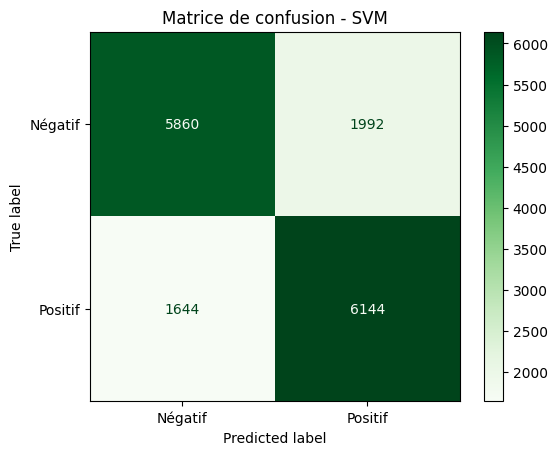

In [30]:
from sklearn.svm import SVC

# Entraîner le modèle
svm_model = SVC()
svm_model.fit(X_train, y_train)

# Faire des prédictions
y_pred_svm = svm_model.predict(X_test)

# Évaluer les performances
print("Rapport de classification pour le SVM :")
print(classification_report(y_test, y_pred_svm))

# Matrice de confusion
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_svm, display_labels=['Négatif', 'Positif'])
disp.plot(cmap="Greens")
plt.title("Matrice de confusion - SVM")
plt.show()


### **RandomForestClassifier :**

Rapport de classification pour Random Forest :
              precision    recall  f1-score   support

           0       0.75      0.75      0.75      7852
           4       0.75      0.74      0.74      7788

    accuracy                           0.75     15640
   macro avg       0.75      0.75      0.75     15640
weighted avg       0.75      0.75      0.75     15640



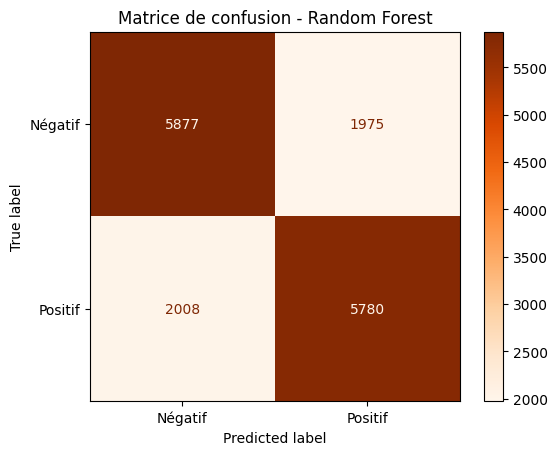

In [31]:
from sklearn.ensemble import RandomForestClassifier

# Entraîner le modèle
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

# Faire des prédictions
y_pred_rf = rf_model.predict(X_test)

# Évaluer les performances
print("Rapport de classification pour Random Forest :")
print(classification_report(y_test, y_pred_rf))

# Matrice de confusion
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_rf, display_labels=['Négatif', 'Positif'])
disp.plot(cmap="Oranges")
plt.title("Matrice de confusion - Random Forest")
plt.show()


### **Gradient Boosting :**

Rapport de classification pour Gradient Boosting :
              precision    recall  f1-score   support

           0       0.78      0.56      0.66      7852
           4       0.66      0.84      0.74      7788

    accuracy                           0.70     15640
   macro avg       0.72      0.70      0.70     15640
weighted avg       0.72      0.70      0.70     15640



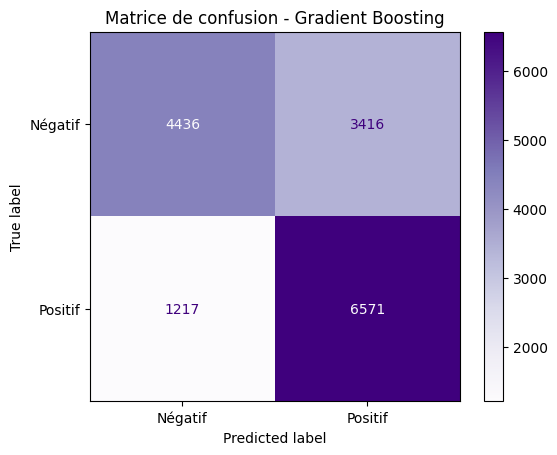

In [32]:
from sklearn.ensemble import GradientBoostingClassifier

# Entraîner le modèle
gb_model = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=3)
gb_model.fit(X_train, y_train)

# Faire des prédictions
y_pred_gb = gb_model.predict(X_test)

# Évaluer les performances
print("Rapport de classification pour Gradient Boosting :")
print(classification_report(y_test, y_pred_gb))

# Matrice de confusion
conf_matrix_gb = confusion_matrix(y_test, y_pred_gb)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_gb, display_labels=['Négatif', 'Positif'])
disp.plot(cmap="Purples")
plt.title("Matrice de confusion - Gradient Boosting")
plt.show()


### **XGBoost**

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:34:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Rapport de classification pour XGBoost :
              precision    recall  f1-score   support

           0       0.78      0.56      0.65      7852
           1       0.65      0.85      0.74      7788

    accuracy                           0.70     15640
   macro avg       0.72      0.70      0.69     15640
weighted avg       0.72      0.70      0.69     15640



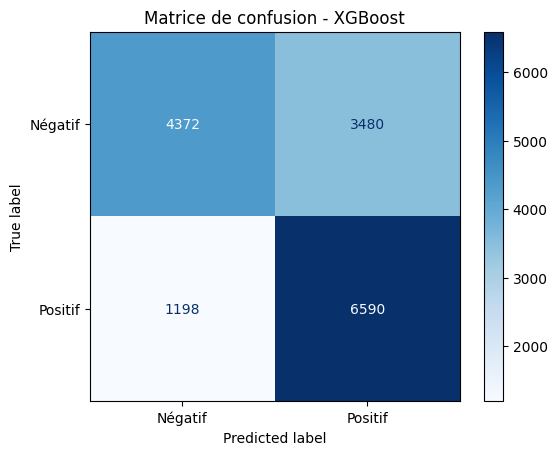

In [37]:
from xgboost import XGBClassifier

# Transformer les labels de 4 à 1
y_train = y_train.replace(4, 1)
y_test = y_test.replace(4, 1)

# Entraîner le modèle
xgb_model = XGBClassifier(n_estimators=200, learning_rate=0.1, max_depth=3, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

# Faire des prédictions
y_pred_xgb = xgb_model.predict(X_test)

# Évaluer les performances
print("Rapport de classification pour XGBoost :")
print(classification_report(y_test, y_pred_xgb))

# Matrice de confusion
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_xgb, display_labels=['Négatif', 'Positif'])
disp.plot(cmap="Blues")
plt.title("Matrice de confusion - XGBoost")
plt.show()
